In [1]:
# BEFORE DOING ANYTHING
# cd Desktop
# git pull

# .. then do stuff ..
# git add .
# git commit -m "your message"
# git push

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import xgboost as xgb
from xgboost import plot_importance

Using TensorFlow backend.


In [2]:
# The top 10 most important features are:
# How many people the property accommodates
# The cleaning fee
# How many other listings the host has (and whether they are a multi-listing host)
# How many days are available to book out of the next 90
# The fee per extra person
# The number of reviews
# The number of bathrooms
# The security deposit
# If the property is in popular area
# The minimum nights stay


raw_data = pd.read_csv("listings.csv.gz")
# free text columns will be dropped for now
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
data = raw_data.drop(cols_to_drop, axis=1)

pd.set_option('display.max_columns', len(raw_data.columns)) # To view all columns
pd.set_option('display.max_rows', 100)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.isna().sum()
data.drop(["host_acceptance_rate", "neighbourhood_group_cleansed", "square_feet", "weekly_price", "monthly_price", 
         "license", "jurisdiction_names"], axis=1, inplace=True)
data.shape

(45053, 72)

In [4]:
# host_listings_count and host_total_listings_count are the same in all but 16 cases. 
# These cases are those where the value is NaN. Therefore one of these columns can be dropped. 
print(sum((data.host_listings_count == data.host_total_listings_count) == False))
data.loc[((data.host_listings_count == data.host_total_listings_count) == False)][:]
data.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


16


In [5]:
# Since all locations in Los Angeles, drop any columns related to location ie state, country
data["smart_location"].value_counts()
lat_long = data[["latitude", "longitude"]]
data.drop(["zipcode", "state", "country", "country_code", "street", "neighbourhood", "city", "latitude", "longitude", 
         "market", "smart_location", "is_location_exact"], axis=1, inplace= True)

In [6]:
# There are multiple columns for minimum and maximum night stays, 
# but the two main ones will be used as there are few differences between e.g. minimum_nights 
# and minimum_minimum_nights. The default (i.e. most frequently applied) min/max night stay values will be used instead.
sum((data.minimum_nights == data.minimum_minimum_nights) == False)
data.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], 
          axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105f80a50>,
      dtype=object)

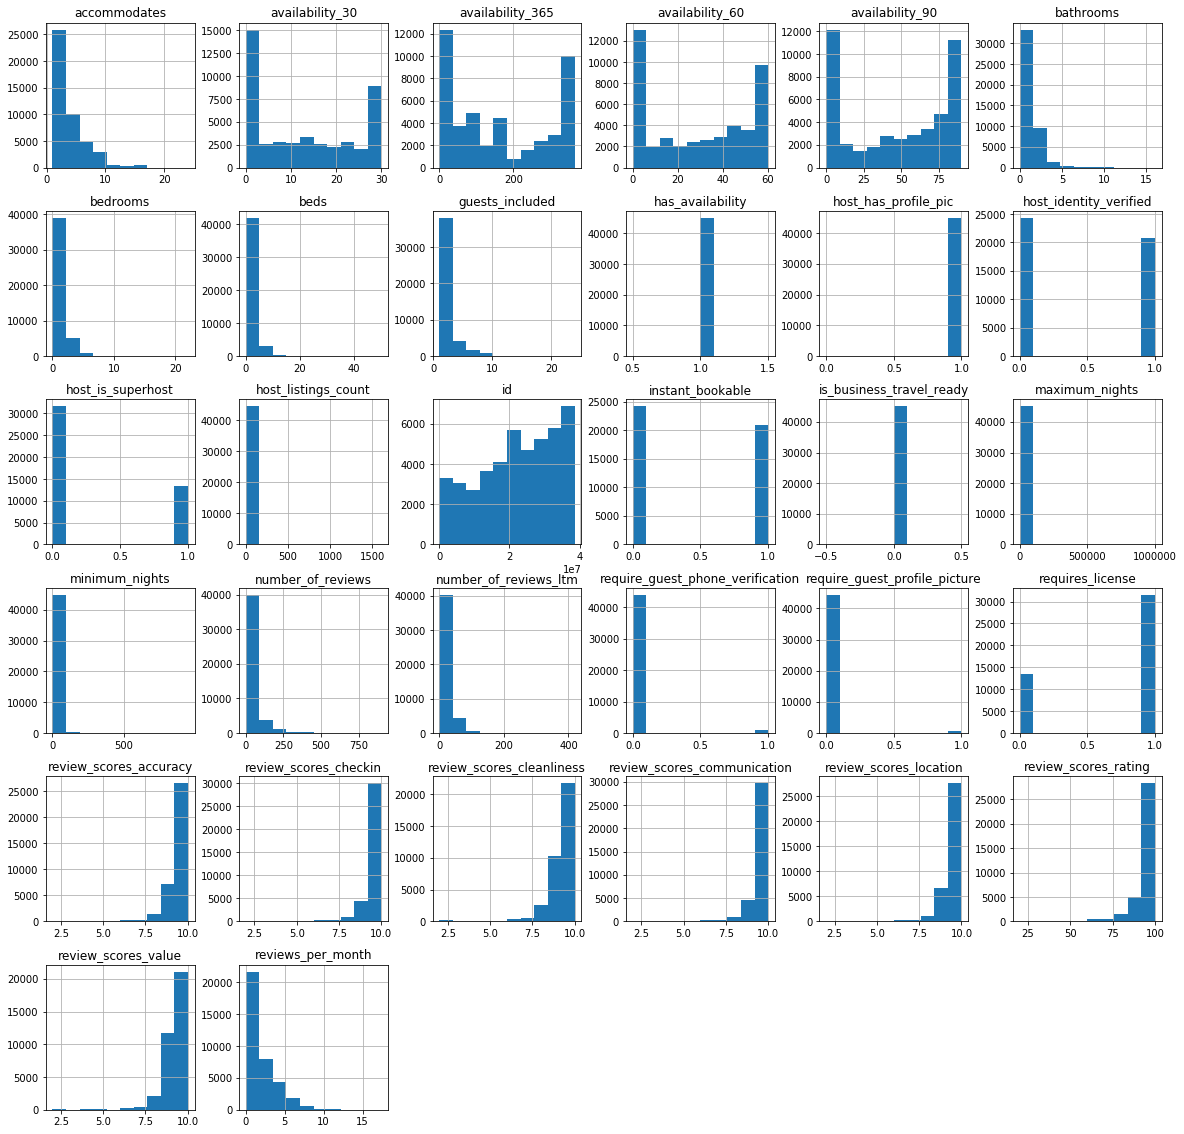

In [7]:
# Replacing columns with f/t with 0/1
data.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
data.hist(figsize=(20,20))

In [8]:
# Can see above that some boolean categories only contain one category and can be dropped:
data.drop(['has_availability', 'host_has_profile_pic', 'host_listings_count', 'is_business_travel_ready'], axis=1, inplace=True)

In [9]:
# Drop experiences_offered, 
print(data['experiences_offered'].value_counts())
data.drop('experiences_offered', axis=1, inplace=True)

none    45053
Name: experiences_offered, dtype: int64


In [10]:
# Now we're at 44 columns
print(data.shape)

(45053, 44)


In [11]:
###############################
## CLEANING INDIVIDUAL COLS ###
###############################

# host_since
# Converting to date time
data.host_since = pd.to_datetime(data.host_since)

# Calculating the number of days
data['host_days_active'] = (datetime(2019, 9, 14) - data.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(data['host_days_active'].mean(),0))
print("Median days as host:", data['host_days_active'].median())

# Replacing null values with the median
data.host_days_active.fillna(data.host_days_active.median(), inplace=True)


Mean days as host: 1448.0
Median days as host: 1417.0


In [12]:
# host_response_time

print("Null values:", data.host_response_time.isna().sum())

prop = round((data.host_response_time.isna().sum()/len(data))*100, 1)
print(f"Proportion: {prop}%")

# Number of rows without a value for host_response_time which have also not yet had a review
# print(len(data[data.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2]))

data.host_response_time.fillna("unknown", inplace=True)
data.host_response_time.value_counts(normalize=True)


Null values: 8294
Proportion: 18.4%


within an hour        0.600293
unknown               0.184094
within a few hours    0.120392
within a day          0.073513
a few days or more    0.021708
Name: host_response_time, dtype: float64

In [13]:
# host_response_rate
data.host_response_rate.value_counts()
print("Null values:", data.host_response_rate.isna().sum())
prop = round((data.host_response_rate.isna().sum()/len(data))*100, 1)
print(f"Proportion: {prop}%")


# Removing the % sign from the host_response_rate string and converting to an integer
data.host_response_rate = data.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(data['host_response_rate'].mean(),0))
print("Median host response rate:", data['host_response_rate'].median())
prop_hund = round(((data.host_response_rate == 100.0).sum()/data.host_response_rate.count())*100,1)
print(f"Proportion of 100% host response rates: {prop_hund}%")

Null values: 8294
Proportion: 18.4%
Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.0%


In [14]:
# Bin into 4 categories 
data.host_response_rate = pd.cut(data.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
data.host_response_rate = data.host_response_rate.astype('str')

# Replace nulls with 'unknown'
data.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
data.host_response_rate.value_counts()

100%       25726
unknown     8294
90-99%      5118
50-89%      4566
0-49%       1349
Name: host_response_rate, dtype: int64

In [15]:
# host_is_superhost

data.host_is_superhost.value_counts()

# There are 16 rows lacking values for each of five different host-related features.
# These rows will be dropped 
data[data.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 
                  'host_identity_verified'] ].isnull().sum(axis=1) == 5]

data.dropna(subset=['host_since'], inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [16]:
# property_type

# Replacing categories that are types of houses or apartments
data.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
data.loc[~data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

data.property_type.value_counts()

House        19390
Apartment    17872
Other         7775
Name: property_type, dtype: int64

In [17]:
# beds, bathrooms, bedrooms

# Replace missing values with the median
for col in ['bathrooms', 'bedrooms', 'beds']:
    data[col].fillna(data[col].median(), inplace=True)
    
# most listings have the same bed_type, so drop this
data.bed_type.value_counts()

data.drop('bed_type', axis=1, inplace=True)

In [18]:
# Amenities is a list of additional features in the property, e.g. whether it has a TV or parking.

# Create a set of all possible amenities
amenities_list = list(data.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
# amenities_set

In [19]:
# 44 cols to begin with
print(data.shape)

# Some amenities are more important than others, make new features for these (One Hot Encoding)
data.loc[data['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
data.loc[data['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
data.loc[data['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
data.loc[data['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
data.loc[data['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
data.loc[data['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
data.loc[data['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
data.loc[data['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
data.loc[data['amenities'].str.contains('TV'), 'tv'] = 1
data.loc[data['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
data.loc[data['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
data.loc[data['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
data.loc[data['amenities'].str.contains('Elevator'), 'elevator'] = 1
data.loc[data['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
data.loc[data['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
data.loc[data['amenities'].str.contains('parking'), 'parking'] = 1
data.loc[data['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
data.loc[data['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
data.loc[data['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
data.loc[data['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
data.loc[data['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
data.loc[data['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
data.loc[data['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
data.loc[data['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
data.loc[data['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
data.loc[data['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
data.loc[data['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
data.loc[data['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

(45037, 44)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [20]:
# Start at 44 because cols 44 thru 72 are the new amenity features

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = data.iloc[:,44:].columns
data[cols_to_replace_nulls] = data[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in data.iloc[:,44:].columns:
    if data[col].sum() < len(data)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
data.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
data.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'nature_and_views', 'smoking_allowed', 'accessible', 'event_suitable']


In [21]:
data.columns[43:] # All the newly added features that we keep

Index(['air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

In [22]:
# price

# Convert to integer
data.price = data.price.str[1:-3]
data.price = data.price.str.replace(",", "")
data.price = data.price.astype('int64')

In [23]:
# security_deposit

print(data.security_deposit.isna().sum())

# Having a missing security deposit is equivalent to having $0 security deposit

data.security_deposit = data.security_deposit.str[1:-3]
data.security_deposit = data.security_deposit.str.replace(",", "")
data.security_deposit.fillna(0, inplace=True)
data.security_deposit = data.security_deposit.astype('int64')

10903


In [24]:
# cleaning_fee

print(data.cleaning_fee.isna().sum())

# Having a missing cleaning fee is equivalent to having $0 cleaning fee
data.cleaning_fee = data.cleaning_fee.str[1:-3]
data.cleaning_fee = data.cleaning_fee.str.replace(",", "")
data.cleaning_fee.fillna(0, inplace=True)
data.cleaning_fee = data.cleaning_fee.astype('int64')

5866


In [25]:
# extra_people

# Having missing value for extra_people is equivalent to 0 extra people allowed
data.extra_people = data.extra_people.str[1:-3]
data.extra_people = data.extra_people.str.replace(",", "")
data.extra_people.fillna(0, inplace=True)
data.extra_people = data.extra_people.astype('int64')

In [26]:
# calendar_updated

data.calendar_updated.value_counts() 
# Unclear as to if this is useful; drop for now
data.drop('calendar_updated', axis=1, inplace=True)

In [27]:
# availability 
# ?? all are highly correlated, which to drop ??

# keep availability_90
data.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [28]:
# first_review and last_review

# Missing values should be kept as an 'unknown' category, and the feature will have to be treated as categorical 
# (and therefore one-hot encoded) rather than numerical.
# Keep missing values because this means it is probably a new listing !! so there's valuable info

print(f"Null values in 'first_review': {round(100*data.first_review.isna().sum()/len(data),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*data.review_scores_rating .isna().sum()/len(data),1)}%")

data.first_review = pd.to_datetime(data.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
data['time_since_first_review'] = (datetime(2019, 9, 14) - data.first_review).astype('timedelta64[D]')

Null values in 'first_review': 18.9%
Null values in 'review_scores_rating': 20.2%


In [29]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    data[col] = pd.cut(data[col], bins=bins, labels=labels, include_lowest=True)
    data[col] = data[col].astype('str')
    data[col].fillna(na_label, inplace=True)
    

In [30]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(data.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [31]:
# Do the same for last_review
data.last_review = pd.to_datetime(data.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
data['time_since_last_review'] = (datetime(2019, 9, 14) - data.last_review).astype('timedelta64[D]')

In [32]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(data.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [33]:
# Dropping last_review - first_review will be kept for EDA and dropped later
data.drop('last_review', axis=1, inplace=True)

In [34]:
data.drop(['time_since_first_review', 'time_since_last_review'], axis=1, inplace=True)

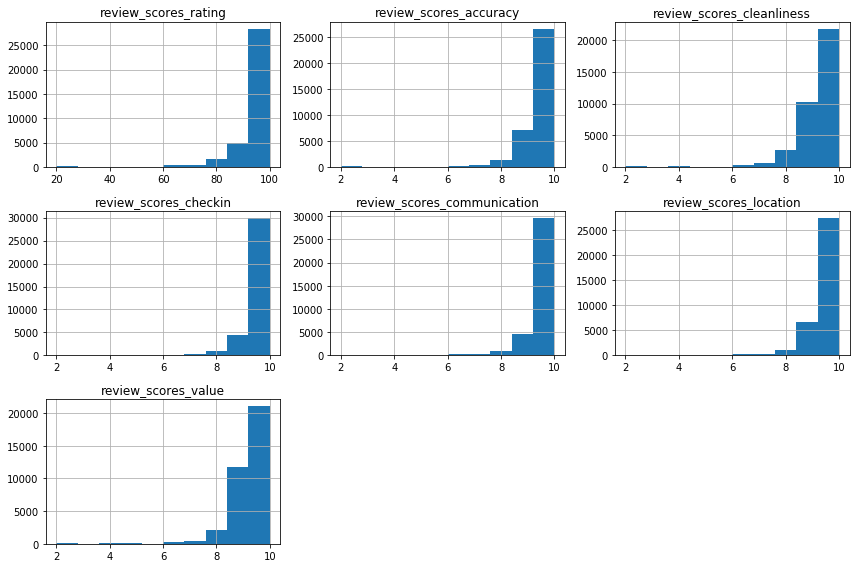

In [35]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(data.columns[data.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    data[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [36]:
variables_to_plot.pop(0)

'review_scores_rating'

In [37]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [38]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [39]:
# cancellation_policy
data.cancellation_policy.value_counts()

# Replacing categories
data.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate',
    'luxury_no_refund': 'strict'
    }, inplace=True)

In [40]:
# Replacing other categories with 'other'
#data.loc[~data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
values = data['neighbourhood_cleansed'].value_counts().keys().to_list()
counts = data['neighbourhood_cleansed'].value_counts().to_list()

low_values = []
for c in range(len(counts)):
    if counts[c] < 50:
        low_values.append(values[c])

# Replacing other categories with 'other'
data.loc[data.neighbourhood_cleansed.isin(low_values), 'neighbourhood_cleansed'] = 'Other'


In [41]:
data.drop('neighbourhood_cleansed', axis=1, inplace=True)

In [42]:
# Dropping features there were useless based on feature importance after Xgboost
data.drop(['number_of_reviews_ltm', 'reviews_per_month','review_scores_communication', 'cooking_basics', 'child_friendly', 'coffee_machine', 
         'outdoor_space', 'host_greeting', 'require_guest_profile_picture', 'secure', 
         'require_guest_phone_verification', 'host_since', 'first_review'], axis=1, inplace= True)

,id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,white_goods,elevator,gym,parking,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,self_check_in
26757,26577964,within an hour,100%,1.0,1.0,Apartment,Entire home/apt,2,1.0,16.0,1.0,159,500,129,1,15,1,1125,86,4,95-100/100,10/10,10/10,10/10,10/10,10/10,1,0,strict_14_with_grace_period,1881.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
34110,32171927,within an hour,100%,0.0,0.0,Apartment,Entire home/apt,2,1.0,22.0,1.0,96,0,38,1,25,1,300,85,14,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,1,1,strict_14_with_grace_period,348.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
42619,37431234,within an hour,90-99%,1.0,1.0,House,Entire home/apt,15,6.5,17.0,14.0,2600,4000,985,16,10,3,1125,90,0,nan,nan,nan,nan,nan,nan,1,0,strict_14_with_grace_period,2374.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


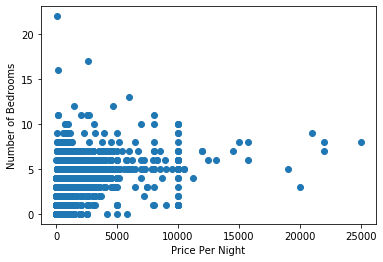

In [43]:
plt.plot(data.price, data.bedrooms, 'o')
plt.xlabel("Price Per Night")
plt.ylabel("Number of Bedrooms")

data[data['bedrooms'] > 15]
# The first two rows are obviously an outliers/ data entered wrong, delete the rows

In [44]:
# The first two rows are obviously an outliers/ data entered wrong, delete the row
data.drop(26757, inplace = True)
data.drop(34110, inplace = True)

## Bin the Price Column
#### Use for linear associator model

In [45]:
# Exploring how scores are distributed

data[data['price'] <= 50] # 6260
data[np.logical_and(data['price'] > 50, data['price'] <= 75)] # 7000
data[np.logical_and(data['price'] > 75, data['price'] <= 100)] # 8000
data[np.logical_and(data['price'] > 100, data['price'] <= 150)] # 9000
data[np.logical_and(data['price'] > 150, data['price'] <= 200)] # 5000
data[np.logical_and(data['price'] > 100, data['price'] <= 200)] # 13880
data[np.logical_and(data['price'] > 200, data['price'] <= 300)] # 3792
data[np.logical_and(data['price'] > 300, data['price'] <= 400)] # 1607
data[np.logical_and(data['price'] > 400, data['price'] <= 500)] # 929
data[np.logical_and(data['price'] > 500, data['price'] <= 600)] # 459
data[np.logical_and(data['price'] > 600, data['price'] <= 700)] # 316
data[np.logical_and(data['price'] > 700, data['price'] <= 1000)] # 718
data[np.logical_and(data['price'] > 1000, data['price'] <= 2000)] # 580
data[np.logical_and(data['price'] > 2000, data['price'] <= 3000)] # 163
data[np.logical_and(data['price'] > 3000, data['price'] <= 4000)] # 92
len(data[np.logical_and(data['price'] > 4000, data['price'] <= 5000)]) # 56
len(data[np.logical_and(data['price'] > 5000, data['price'] <= 6000)])# 17
len(data[np.logical_and(data['price'] > 6000, data['price'] <= 7000)]) # 10
len(data[np.logical_and(data['price'] > 7000, data['price'] <= 8000)]) # 19
len(data[np.logical_and(data['price'] > 8000, data['price'] <= 9000)]) # 8
len(data[np.logical_and(data['price'] > 9000, data['price'] <= 10000)]) # 33
len(data[np.logical_and(data['price'] > 10000, data['price'] <= 15000)]) # 9
len(data[np.logical_and(data['price'] > 15000, data['price'] <= 20000)]) # 4
len(data[data['price'] > 20000]) # 4

# sns.set_style('whitegrid')
# data['price'].plot(kind='hist')
# Clearly very imbalanced

4

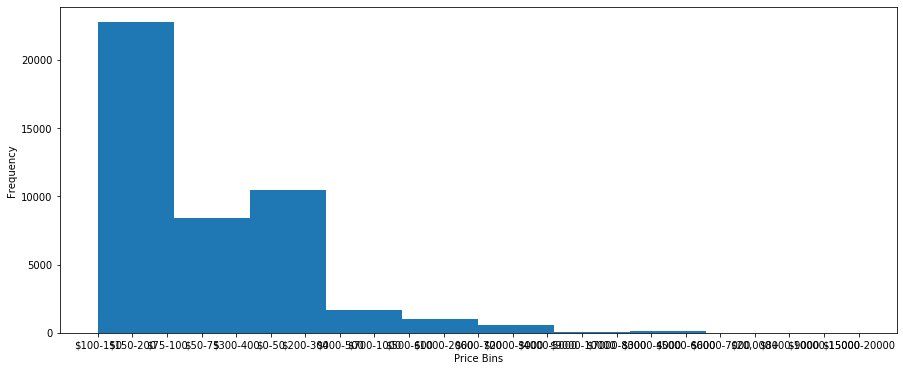

In [46]:
bins = [0, 50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 1000, 2000, 3000, 4000, 5000,
        6000, 7000, 8000, 9000, 10000, 15000, 20000, max(data.price)]
labels = ['$0-50',
          '$50-75',
          '$75-100',
          '$100-150',
          '$150-200',
          '$200-300',
          '$300-400', 
          '$400-500', 
          '$500-600',
          '$600-700', 
          '$700-1000',
          '$1000-2000',
          '$2000-3000',
          '$3000-4000',
          '$4000-5000',
          '$5000-6000',
          '$6000-7000',
          '$7000-8000',
          '$8000-9000',
          '$9000-10000',
          '$10000-15000',
          '$15000-20000',
           '$20,000+']
na_label = 'no price'

data_p = data.copy() # save for later when need price bins
data_p['price_bin'] = pd.cut(data_p['price'], bins=bins, labels=labels, include_lowest=True)
# data['price'].plot(kind='hist', bins = bins)

# sns.set_style('whitegrid')

plt.figure(figsize=(15,6))
plt.hist(data_p['price_bin'])
plt.xlabel("Price Bins")
plt.ylabel("Frequency")
plt.show()

### Preparing the data for modeling

In [47]:
transformed_data = pd.get_dummies(data)

## Do heatmap later, possibly drop some


In [48]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'beds', 'bedrooms','cleaning_fee', 'extra_people', 
                     'host_days_active', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_data[col] = transformed_data[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_data[col] = np.log(transformed_data[col])

In [49]:
transformed_data

,id,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,requires_license,instant_bookable,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,white_goods,elevator,gym,parking,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_checkin_nan,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,109,0.0,1.0,1.791759,0.693147,0.693147,1.098612,4.804021,6.214608,5.480639,3,3.218876,3.401197,6.593045,0,0.693147,0,0,4096.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,344,0.0,1.0,1.791759,0.000000,1.098612,1.098612,5.123964,-4.605170,4.605170,6,-4.605170,0.693147,2.639057,0,1.791759,0,1,4082.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,2708,1.0,1.0,0.000000,0.405465,0.000000,0.000000,4.369448,6.173786,4.465908,1,-4.605170,3.332205,5.902633,1,3.044522,1,1,4015.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,2732,1.0,0.0,0.000000,0.000000,0.000000,0.000000,4.941642,-4.605170,4.605170,1,-4.605170,0.000000,5.192957,71,2.944439,1,0,4014.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,2864,0.0,1.0,0.693147,0.000000,0.000000,0.000000,4.382027,4.605170,4.317488,1,3.218876,0.693147,6.593045,0,-4.605170,0,0,4006.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45048,38603385,0.0,0.0,0.000000,0.000000,-4.605170,0.000000,4.488636,-4.605170,-4.605170,1,-4.605170,0.000000,7.025538,83,-4.605170,1,0,518.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0
45049,38603626,1.0,1.0,0.693147,0.000000,0.000000,0.000000,4.499810,-4.605170,3.218876,1,-4.605170,1.098612,7.025538,90,-4.605170,1,1,1125.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,

## XGBoost 

In [50]:
# Separating X and y
X = transformed_data.drop('price', axis=1)
y = transformed_data.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [51]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.2 minutes

Training MSE: 0.1876
Validation MSE: 0.1882

Training r2: 0.7544
Validation r2: 0.7498


In [52]:
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print(np.exp(val_preds_xgb_reg))
print(np.exp(y_test))

[ 95.8444   111.625916 130.09044  ... 213.18457   68.502914  53.298923]
3551      79.0
21623    150.0
39236    130.0
18843     60.0
2492      88.0
         ...  
19088    400.0
19592    105.0
35259    299.0
14359     66.0
2803      45.0
Name: price, Length: 9007, dtype: float64


In [53]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
#ft_weights_xgb_reg


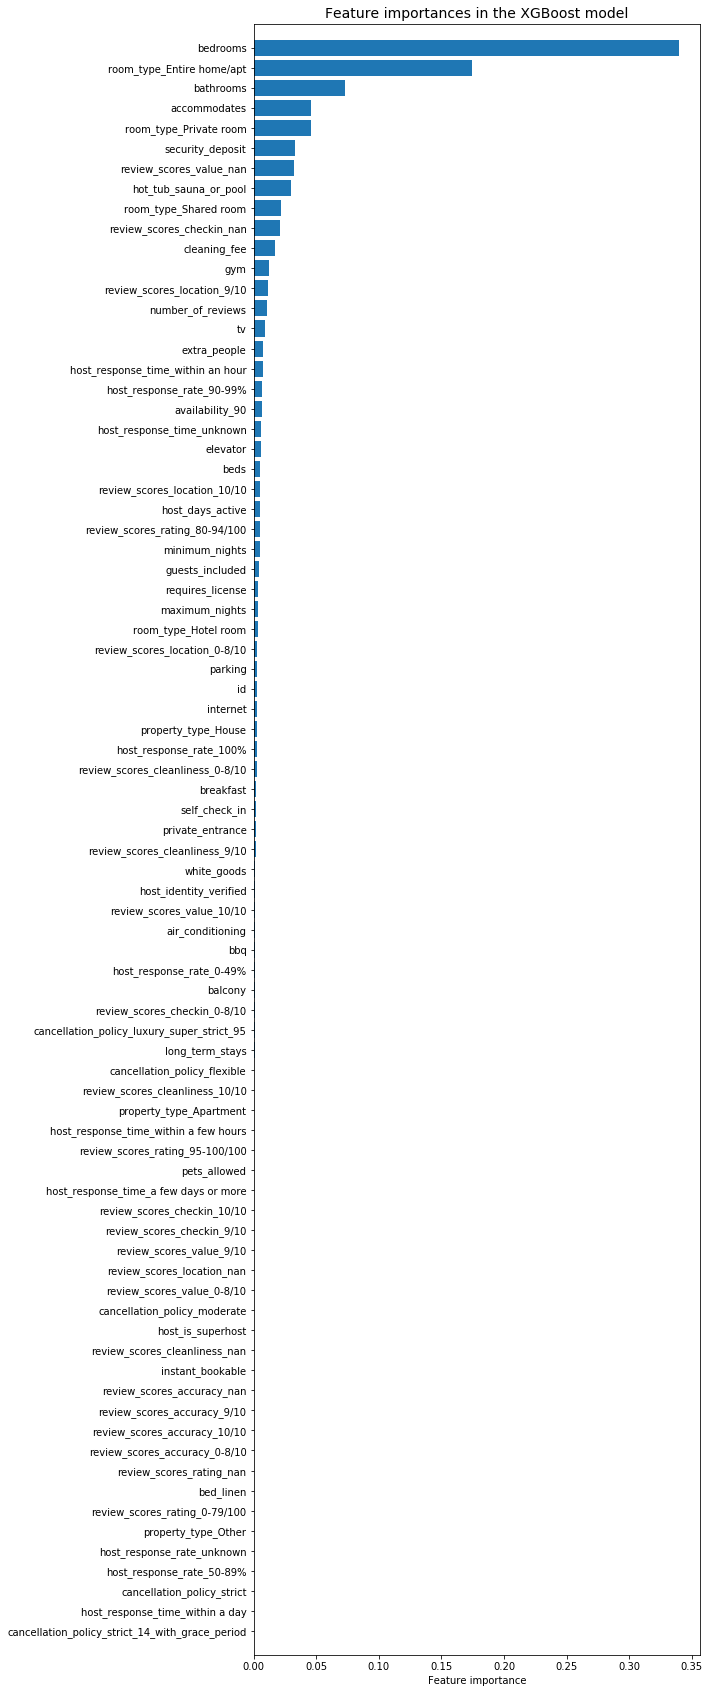

In [54]:
# Plotting feature importances
plt.figure(figsize=(8,30))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## NEURAL NETWORK: 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               10368     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 109,441
Trainable params: 109,441
Non-trainable params: 0
_________________________________________________________________
None


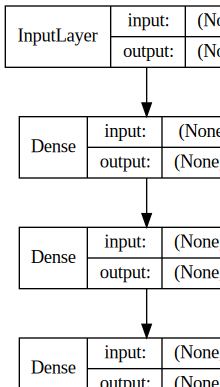

In [55]:

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [56]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 32425 samples, validate on 3603 samples
Epoch 1/100
32425/32425 [==============================] - 2s 57us/step - loss: 1.1119 - mean_squared_error: 1.1119 - val_loss: 0.2900 - val_mean_squared_error: 0.2900
Epoch 2/100
32425/32425 [==============================] - 1s 30us/step - loss: 0.2625 - mean_squared_error: 0.2625 - val_loss: 0.2614 - val_mean_squared_error: 0.2614
Epoch 3/100
32425/32425 [==============================] - 1s 30us/step - loss: 0.2311 - mean_squared_error: 0.2311 - val_loss: 0.2417 - val_mean_squared_error: 0.2417
Epoch 4/100
32425/32425 [==============================] - 1s 31us/step - loss: 0.2154 - mean_squared_error: 0.2154 - val_loss: 0.2334 - val_mean_squared_error: 0.2334
Epoch 5/100
32425/32425 [==============================] - 1s 32us/step - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2348 - val_mean_squared_error: 0.2348
Epoch 6/100
32425/32425 [==============================] - 1s 33us/step - loss: 0.1954 - mean_squared_error: 0.

32425/32425 [==============================] - 1s 30us/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.2788 - val_mean_squared_error: 0.2788
Epoch 50/100
32425/32425 [==============================] - 1s 29us/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.2802 - val_mean_squared_error: 0.2802
Epoch 51/100
32425/32425 [==============================] - 1s 30us/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.2817 - val_mean_squared_error: 0.2817
Epoch 52/100
32425/32425 [==============================] - 1s 30us/step - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.2712 - val_mean_squared_error: 0.2712
Epoch 53/100
32425/32425 [==============================] - 1s 32us/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.2701 - val_mean_squared_error: 0.2701
Epoch 54/100
32425/32425 [==============================] - 1s 30us/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.2792 - val_mean_squared_error: 0.2792

32425/32425 [==============================] - 1s 30us/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.2775 - val_mean_squared_error: 0.2775
Epoch 98/100
32425/32425 [==============================] - 1s 30us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.2766 - val_mean_squared_error: 0.2766
Epoch 99/100
32425/32425 [==============================] - 1s 37us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.2814 - val_mean_squared_error: 0.2814
Epoch 100/100
32425/32425 [==============================] - 1s 31us/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.2819 - val_mean_squared_error: 0.2819
Time taken to run: 1.7 minutes


In [57]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. 
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0414
Validation MSE: 0.2684

Training r2: 0.9458
Validation r2: 0.6431


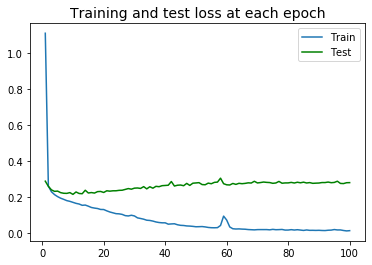

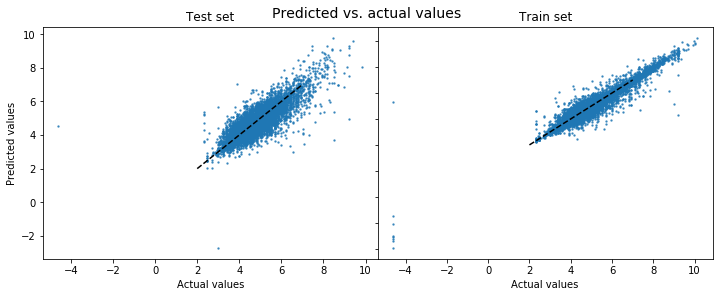

In [58]:
nn_model_evaluation(nn2)


BREAKING THE MODEL

In [59]:
raw_corrupt_data = pd.read_csv("listings_corrupted.csv")
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
corrupt_data = raw_corrupt_data.drop(cols_to_drop, axis=1)

pd.set_option('display.max_columns', len(raw_corrupt_data.columns)) # To view all columns
pd.set_option('display.max_rows', 100)


# In[204]:


corrupt_data.isna().sum()
corrupt_data.drop(["host_acceptance_rate", "neighbourhood_group_cleansed", "square_feet", "weekly_price", "monthly_price",
         "license", "jurisdiction_names"], axis=1, inplace=True)
corrupt_data.shape


# In[4]:


# host_listings_count and host_total_listings_count are the same in all but 16 cases.
# These cases are those where the value is NaN. Therefore one of these columns can be dropped.
corrupt_data.loc[((corrupt_data.host_listings_count == corrupt_data.host_total_listings_count) == False)][:]
corrupt_data.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


# In[5]:


# Since all locations in Los Angeles, drop any columns related to location ie state, country
corrupt_data["smart_location"].value_counts()
lat_long = corrupt_data[["latitude", "longitude"]]
corrupt_data.drop(["zipcode", "state", "country", "country_code", "street", "neighbourhood", "city", "latitude", "longitude",
         "market", "smart_location", "is_location_exact"], axis=1, inplace= True)


# In[6]:


# There are multiple columns for minimum and maximum night stays,
# but the two main ones will be used as there are few differences between e.g. minimum_nights
# and minimum_minimum_nights. The default (i.e. most frequently applied) min/max night stay values will be used instead.
sum((corrupt_data.minimum_nights == corrupt_data.minimum_minimum_nights) == False)
corrupt_data.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'],
        axis=1, inplace=True)


# In[ ]:


# Replacing columns with f/t with 0/1
corrupt_data.replace({'f': 0, 't': 1}, inplace=True)
    
  


# Can see above that some boolean categories only contain one category and can be dropped:
corrupt_data.drop(['has_availability', 'host_has_profile_pic', 'host_listings_count', 'is_business_travel_ready'], axis=1, inplace=True)


# In[9]:


# Drop experiences_offered,
print(corrupt_data['experiences_offered'].value_counts())
corrupt_data.drop('experiences_offered', axis=1, inplace=True)


# In[10]:


# Now we're at 44 columns


# In[11]:


###############################
## CLEANING INDIVIDUAL COLS ###
###############################

# host_since
# Converting to date time
corrupt_data.host_since = pd.to_datetime(corrupt_data.host_since)

# Calculating the number of days
corrupt_data['host_days_active'] = (datetime(2019, 9, 14) - corrupt_data.host_since).astype('timedelta64[D]')

# Replacing null values with the median
corrupt_data.host_days_active.fillna(corrupt_data.host_days_active.median(), inplace=True)


# In[12]:


# host_response_time


prop = round((corrupt_data.host_response_time.isna().sum()/len(corrupt_data))*100, 1)


# Number of rows without a value for host_response_time which have also not yet had a review
# print(len(corrupt_data[corrupt_data.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2]))

corrupt_data.host_response_time.fillna("unknown", inplace=True)
corrupt_data.host_response_time.value_counts(normalize=True)


# In[13]:


# host_response_rate
corrupt_data.host_response_rate.value_counts()
prop = round((corrupt_data.host_response_rate.isna().sum()/len(corrupt_data))*100, 1)


# Removing the % sign from the host_response_rate string and converting to an integer
corrupt_data.host_response_rate = corrupt_data.host_response_rate.str[:-1].astype('float64')


prop_hund = round(((corrupt_data.host_response_rate == 100.0).sum()/corrupt_data.host_response_rate.count())*100,1)



# In[14]:


# Bin into 4 categories
corrupt_data.host_response_rate = pd.cut(corrupt_data.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
corrupt_data.host_response_rate = corrupt_data.host_response_rate.astype('str')

# Replace nulls with 'unknown'
corrupt_data.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
corrupt_data.host_response_rate.value_counts()


# In[15]:


# host_is_superhost

corrupt_data.host_is_superhost.value_counts()

# There are 16 rows lacking values for each of five different host-related features.
# These rows will be dropped
corrupt_data[corrupt_data.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
              'host_identity_verified'] ].isnull().sum(axis=1) == 5]

corrupt_data.dropna(subset=['host_since'], inplace=True)


# In[16]:


# property_type

# Replacing categories that are types of houses or apartments
corrupt_data.property_type.replace({
                         'Townhouse': 'House',
                         'Serviced apartment': 'Apartment',
                         'Loft': 'Apartment',
                         'Bungalow': 'House',
                         'Cottage': 'House',
                         'Villa': 'House',
                         'Tiny house': 'House',
                         'Earth house': 'House',
                         'Chalet': 'House'
                         }, inplace=True)

# Replacing other categories with 'other'
corrupt_data.loc[~corrupt_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

corrupt_data.property_type.value_counts()


# In[17]:


# beds, bathrooms, bedrooms

# Replace missing values with the median
for col in ['bathrooms', 'bedrooms', 'beds']:
    corrupt_data[col].fillna(corrupt_data[col].median(), inplace=True)

# most listings have the same bed_type, so drop this
corrupt_data.bed_type.value_counts()

corrupt_data.drop('bed_type', axis=1, inplace=True)


# In[18]:


# Amenities is a list of additional features in the property, e.g. whether it has a TV or parking.

# Create a set of all possible amenities
amenities_list = list(corrupt_data.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
# amenities_set


# In[19]:


# 44 cols to begin with


# Some amenities are more important than others, make new features for these (One Hot Encoding)
corrupt_data.loc[corrupt_data['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('TV'), 'tv'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Elevator'), 'elevator'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('parking'), 'parking'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
corrupt_data.loc[corrupt_data['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1


# In[20]:


# Start at 44 because cols 44 thru 72 are the new amenity features

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = corrupt_data.iloc[:,44:].columns
corrupt_data[cols_to_replace_nulls] = corrupt_data[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in corrupt_data.iloc[:,44:].columns:
    if corrupt_data[col].sum() < len(corrupt_data)/10:
        infrequent_amenities.append(col)

# Dropping infrequent amenity features
corrupt_data.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
corrupt_data.drop('amenities', axis=1, inplace=True)


# In[21]:


corrupt_data.columns[43:] # All the newly added features that we keep


# In[22]:


# price

# Convert to integer
corrupt_data.price = corrupt_data.price.str[1:-3]
corrupt_data.price = corrupt_data.price.str.replace(",", "")
corrupt_data.price = corrupt_data.price.astype('int64')


# In[23]:


# security_deposit



# Having a missing security deposit is equivalent to having $0 security deposit

corrupt_data.security_deposit = corrupt_data.security_deposit.str[1:-3]
corrupt_data.security_deposit = corrupt_data.security_deposit.str.replace(",", "")
corrupt_data.security_deposit.fillna(0, inplace=True)
corrupt_data.security_deposit = corrupt_data.security_deposit.astype('int64')


# In[24]:


# cleaning_fee



# Having a missing cleaning fee is equivalent to having $0 cleaning fee
corrupt_data.cleaning_fee = corrupt_data.cleaning_fee.str[1:-3]
corrupt_data.cleaning_fee = corrupt_data.cleaning_fee.str.replace(",", "")
corrupt_data.cleaning_fee.fillna(0, inplace=True)
corrupt_data.cleaning_fee = corrupt_data.cleaning_fee.astype('int64')


# In[25]:


# extra_people

# Having missing value for extra_people is equivalent to 0 extra people allowed
corrupt_data.extra_people = corrupt_data.extra_people.str[1:-3]
corrupt_data.extra_people = corrupt_data.extra_people.str.replace(",", "")
corrupt_data.extra_people.fillna(0, inplace=True)
corrupt_data.extra_people = corrupt_data.extra_people.astype('int64')


# In[26]:


# calendar_updated

corrupt_data.calendar_updated.value_counts()
# Unclear as to if this is useful; drop for now
corrupt_data.drop('calendar_updated', axis=1, inplace=True)


# In[27]:


# availability
# ?? all are highly correlated, which to drop ??

# keep availability_90
corrupt_data.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)


# In[28]:


# first_review and last_review

# Missing values should be kept as an 'unknown' category, and the feature will have to be treated as categorical
# (and therefore one-hot encoded) rather than numerical.
# Keep missing values because this means it is probably a new listing !! so there's valuable info

print(f"Null values in 'first_review': {round(100*corrupt_data.first_review.isna().sum()/len(corrupt_data),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*corrupt_data.review_scores_rating .isna().sum()/len(corrupt_data),1)}%")

corrupt_data.first_review = pd.to_datetime(corrupt_data.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
corrupt_data['time_since_first_review'] = (datetime(2019, 9, 14) - corrupt_data.first_review).astype('timedelta64[D]')


# In[29]:


def bin_column(col, bins, labels, na_label='unknown'):
    """
        Takes in a column name, bin cut points and labels, replaces the original column with a
        binned version, and replaces nulls (with 'unknown' if unspecified).
        """
    corrupt_data[col] = pd.cut(corrupt_data[col], bins=bins, labels=labels, include_lowest=True)
    corrupt_data[col] = corrupt_data[col].astype('str')
    corrupt_data[col].fillna(na_label, inplace=True)



# In[30]:


# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(corrupt_data.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')


# In[31]:


# Do the same for last_review
corrupt_data.last_review = pd.to_datetime(corrupt_data.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
corrupt_data['time_since_last_review'] = (datetime(2019, 9, 14) - corrupt_data.last_review).astype('timedelta64[D]')


# In[32]:


# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(corrupt_data.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')


# In[33]:


# Dropping last_review - first_review will be kept for EDA and dropped later
corrupt_data.drop('last_review', axis=1, inplace=True)


# In[34]:


corrupt_data.drop(['time_since_first_review', 'time_since_last_review'], axis=1, inplace=True)


# In[35]:







# In[37]:


# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')


# In[38]:


# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')


# In[39]:


# cancellation_policy
corrupt_data.cancellation_policy.value_counts()

# Replacing categories
corrupt_data.cancellation_policy.replace({
                               'super_strict_30': 'strict_14_with_grace_period',
                               'super_strict_60': 'strict_14_with_grace_period',
                               'strict': 'strict_14_with_grace_period',
                               'luxury_moderate': 'moderate',
                               'luxury_no_refund': 'strict'
                               }, inplace=True)


# In[40]:


# Replacing other categories with 'other'
#corrupt_data.loc[~corrupt_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
values = corrupt_data['neighbourhood_cleansed'].value_counts().keys().to_list()
counts = corrupt_data['neighbourhood_cleansed'].value_counts().to_list()

low_values = []
for c in range(len(counts)):
    if counts[c] < 50:
        low_values.append(values[c])

# Replacing other categories with 'other'
corrupt_data.loc[corrupt_data.neighbourhood_cleansed.isin(low_values), 'neighbourhood_cleansed'] = 'Other'


# In[41]:


corrupt_data.drop('neighbourhood_cleansed', axis=1, inplace=True)


# In[42]:


# Dropping features there were useless based on feature importance after Xgboost
corrupt_data.drop(['number_of_reviews_ltm', 'reviews_per_month','review_scores_communication', 'cooking_basics', 'child_friendly', 'coffee_machine',
         'outdoor_space', 'host_greeting', 'require_guest_profile_picture', 'secure',
         'require_guest_phone_verification', 'host_since', 'first_review'], axis=1, inplace= True)


# In[ ]:


corrupt_data[corrupt_data['bedrooms'] > 15]
# The first two rows are obviously an outliers/ data entered wrong, delete the rows


# In[44]:


# The first two rows are obviously an outliers/ data entered wrong, delete the row
corrupt_data.drop(26757, inplace = True)
corrupt_data.drop(34110, inplace = True)


# ## Bin the Price Column
# #### Use for linear associator model

# In[94]:


# Exploring how scores are distributed

corrupt_data[corrupt_data['price'] <= 50] # 6260
corrupt_data[np.logical_and(corrupt_data['price'] > 50, corrupt_data['price'] <= 75)] # 7000
corrupt_data[np.logical_and(corrupt_data['price'] > 75, corrupt_data['price'] <= 100)] # 8000
corrupt_data[np.logical_and(corrupt_data['price'] > 100, corrupt_data['price'] <= 150)] # 9000
corrupt_data[np.logical_and(corrupt_data['price'] > 150, corrupt_data['price'] <= 200)] # 5000
corrupt_data[np.logical_and(corrupt_data['price'] > 100, corrupt_data['price'] <= 200)] # 13880
corrupt_data[np.logical_and(corrupt_data['price'] > 200, corrupt_data['price'] <= 300)] # 3792
corrupt_data[np.logical_and(corrupt_data['price'] > 300, corrupt_data['price'] <= 400)] # 1607
corrupt_data[np.logical_and(corrupt_data['price'] > 400, corrupt_data['price'] <= 500)] # 929
corrupt_data[np.logical_and(corrupt_data['price'] > 500, corrupt_data['price'] <= 600)] # 459
corrupt_data[np.logical_and(corrupt_data['price'] > 600, corrupt_data['price'] <= 700)] # 316
corrupt_data[np.logical_and(corrupt_data['price'] > 700, corrupt_data['price'] <= 1000)] # 718
corrupt_data[np.logical_and(corrupt_data['price'] > 1000, corrupt_data['price'] <= 2000)] # 580
corrupt_data[np.logical_and(corrupt_data['price'] > 2000, corrupt_data['price'] <= 3000)] # 163
corrupt_data[np.logical_and(corrupt_data['price'] > 3000, corrupt_data['price'] <= 4000)] # 92
len(corrupt_data[np.logical_and(corrupt_data['price'] > 4000, corrupt_data['price'] <= 5000)]) # 56
len(corrupt_data[np.logical_and(corrupt_data['price'] > 5000, corrupt_data['price'] <= 6000)])# 17
len(corrupt_data[np.logical_and(corrupt_data['price'] > 6000, corrupt_data['price'] <= 7000)]) # 10
len(corrupt_data[np.logical_and(corrupt_data['price'] > 7000, corrupt_data['price'] <= 8000)]) # 19
len(corrupt_data[np.logical_and(corrupt_data['price'] > 8000, corrupt_data['price'] <= 9000)]) # 8
len(corrupt_data[np.logical_and(corrupt_data['price'] > 9000, corrupt_data['price'] <= 10000)]) # 33
len(corrupt_data[np.logical_and(corrupt_data['price'] > 10000, corrupt_data['price'] <= 15000)]) # 9
len(corrupt_data[np.logical_and(corrupt_data['price'] > 15000, corrupt_data['price'] <= 20000)]) # 4
len(corrupt_data[corrupt_data['price'] > 20000]) # 4

# sns.set_style('whitegrid')
# corrupt_data['price'].plot(kind='hist')
# Clearly very imbalanced


# In[140]:


bins = [0, 50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 1000, 2000, 3000, 4000, 5000,
        6000, 7000, 8000, 9000, 10000, 15000, 20000, max(corrupt_data.price)]
labels = ['$0-50',
          '$50-75',
          '$75-100',
          '$100-150',
          '$150-200',
          '$200-300',
          '$300-400',
          '$400-500',
          '$500-600',
          '$600-700',
          '$700-1000',
          '$1000-2000',
          '$2000-3000',
          '$3000-4000',
          '$4000-5000',
          '$5000-6000',
          '$6000-7000',
          '$7000-8000',
          '$8000-9000',
          '$9000-10000',
          '$10000-15000',
          '$15000-20000',
          '$20,000+']
na_label = 'no price'

corrupt_data_p = corrupt_data.copy() # save for later when need price bins
corrupt_data_p['price_bin'] = pd.cut(corrupt_data_p['price'], bins=bins, labels=labels, include_lowest=True)
# corrupt_data['price'].plot(kind='hist', bins = bins)



# ### Preparing the data for modeling

# In[50]:


transformed_corrupt_data = pd.get_dummies(corrupt_data)

## Do heatmap later, possibly drop some


# In[220]:


numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'beds', 'bedrooms','cleaning_fee', 'extra_people',
                     'host_days_active', 'maximum_nights', 'minimum_nights',
                     'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_corrupt_data[col] = transformed_corrupt_data[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_corrupt_data[col] = np.log(transformed_corrupt_data[col])

# Separating X and y

C_X = transformed_corrupt_data.drop('price', axis=1)
C_y = transformed)corrupt__data.price

# Scaling
C_scaler = StandardScaler()
C_X = pd.DataFrame(scaler.fit_transform(C_X), columns=list(C_X.columns))

# Splitting into train and test sets
C_X_train, C_X_test, C_y_train, C_y_test = train_test_split(C_X, C_y, test_size=0.2, random_state=123)


SyntaxError: invalid syntax (<ipython-input-59-333b89423a2e>, line 626)

In [ ]:
nn_model_evaluation(nn2,0,C_X_train,C_X_test,C_y_train,C_y_test):

In [ ]:
#######################
## HELPER FUNCTIONS  ##
#######################

# Multiplies a scalar and vectors
def scalar_times_vector(scalar, a, dim):
    B = np.zeros(dim)
    for i in range(dim):
        B[i] = scalar * a[i]
    return B

# Widrow Hoff learning rule 
def Widrow_Hoff(k, g, g_prime, f, dim):
    length_f = np.linalg.norm(f)
    difference_vector = np.subtract(g, g_prime)
    weighted_vector = k * difference_vector
    deltaA = np.outer(g, np.transpose(f))
    return deltaA, weighted_vector

### Get Data Ready for Modeling

In [ ]:
# data['price_bins'] holds the price bins
# Need to binary encode
y = data_p['price_bin']
data_p.drop('price_bin', axis=1, inplace=True)

transformed_data = pd.get_dummies(data_p)

numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'beds', 'bedrooms','cleaning_fee', 'extra_people', 
                     'host_days_active', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_data[col] = transformed_data[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_data[col] = np.log(transformed_data[col])
    
# Separating X and y
X = transformed_data.drop('price', axis=1)

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
train_X = []
n = X_train.shape[0] # The number of ROWS
print("Number of rows: ", n)
dim = X_train.shape[1] # The number of COLUMNS (features)
print("Number of features (cols): ", dim)

for key,value in X_train.iterrows():
    f = value.to_numpy()
    f = f.reshape((dim,1))
    # Center and Scale
    f = f - f.mean()
    f = f / np.linalg.norm(f)
    train_X.append(f)
    
# y_train needs to be array of arrays
target = []
G_set = y_train.values

for i in range(y_train.shape[0]):
    if G_set[i] == '$0-50':
        target.append(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$50-75':
        target.append(np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$75-100':
        target.append(np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$100-150':
        target.append(np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$150-200':
        target.append(np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$200-300':
        target.append(np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$300-400':
        target.append(np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$400-500':
        target.append(np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$500-600':
        target.append(np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$600-700':
        target.append(np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$700-1000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$1000-2000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$2000-3000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$3000-4000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$4000-5000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$5000-6000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$6000-7000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$7000-8000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$8000-9000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]).reshape(23,1))
    elif G_set[i] == '$9000-10000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]).reshape(23,1))
    elif G_set[i] == '$10000-15000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]).reshape(23,1))
    elif G_set[i] == '$15000-20000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(23,1))
    elif G_set[i] == '$20,000+':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]).reshape(23,1))
        
target_X = []
for g in target:
    MEAN = g.mean()
    LENGTH = np.linalg.norm(g)
    g = g - g.mean()
    g = g / np.linalg.norm(g)
    target_X.append(g)
    

In [ ]:
print(len(train_X))
print(len(target_X))

In [ ]:
##########################
## WIDROW-HOFF LEARNING ##
#########################

dim = len(train_X) # NUMBER OF ROWS
n =  80 # NUMBER OF FEATURES (COLS)
m = 23 # NUMBER OF ROWS IN TARGET VALUES
A_i = [ np.outer(target_X[i], np.transpose(train_X[i])) for i in range(dim) ]

# Form the overall connectivity matrix A
# INITTIAL A MATRIX: 4x17
A = np.zeros((m,n))
for i in range(dim):
    A = np.add(A, A_i[i])
print(A.shape)
# Compute the output for each stored vector fi
G_prime = [ A.dot(train_X[i]) for i in range(dim) ]
print(len(G_prime))

learned = np.zeros(dim)
count = 0
converged = False
oscillate_input = False
errorThreshold = 0.0000001;
Errors = []
SSEs = []
k = 0.9

# Choose random pairs and store in array
randints = np.random.choice(20,20, replace=False)

while converged == False:
    mse = 0
    # Pick a random pair of f and g vectors
    r = randints[count]
    f = train_X[r]
    g = target_X[r]
    g_prime = A.dot(f)
    learned[count] = 1
    
    #new_error = np.linalg.norm(error)
    deltaA, error = Widrow_Hoff(k, g, g_prime, f, dim)
    A = np.add(A, deltaA)
    error_length = np.linalg.norm(error)
    Errors.append(error_length)
    SSE = np.trace(np.dot(error.T,error))
    SSEs.append(SSE)

    print("Current Error:", SSE)
    
    #if (abs(np.linalg.norm(error) - new_error) / np.linalg.norm(error) < errorThreshold) and (sum(learned) == n):
    #if (abs(error_length) < errorThreshold):
    if SSE < errorThreshold:
        print("SSE:", SSE)
        #print("Error: ", abs(error_length))
        print("Error Threshold: ", errorThreshold)
        print("Number of trials: ", count)
        converged = True
        
    count = count + 1;
    k =  k - .05

In [ ]:
plt.plot(Errors,'-')
plt.axhline(y=0,color="red")
plt.title("Delta Learning Rule, k= 0.85")
plt.show()

In [ ]:
plt.plot(SSEs, '-')
plt.axhline(y=0,color="red")
plt.title("Delta Learning Rule, k= 0.85")
plt.show()

In [ ]:
##################################
## CLASSIFICATIONS FOR TRAINING ##
##################################
# Now get target values again:

G_prime = [ A.dot(train_X[i]) for i in range(dim) ]

y_pred = []
for g in G_prime:
    target = g*LENGTH + MEAN
    # The max arg represents the classification of price
    max_arg = np.argmax(target)
    if max_arg == 0:
        price_bin = '$0-50'
    elif max_arg == 1:
        price_bin = '$50-75'
    elif max_arg == 2:
        price_bin = '$75-100'
    elif max_arg == 3:
        price_bin = '$100-150'
    elif max_arg == 4:
        price_bin = '$150-200'
    elif max_arg == 5: 
        price_bin = '$200-300'
    elif max_arg == 6:
        price_bin = '$300-400'
    elif max_arg == 7:
        price_bin = '$400-500'
    elif max_arg == 8:
        price_bin = '$500-600'
    elif max_arg == 9:
        price_bin = '$600-700'
    elif max_arg == 10:
        price_bin = '$700-1000'
    elif max_arg == 11:
        price_bin = '$1000-2000'
    elif max_arg == 12:
        price_bin = '$2000-3000'
    elif max_arg == 13:
        price_bin = '$3000-4000'
    elif max_arg == 14:
        price_bin = '$4000-5000'
    elif max_arg == 15:
        price_bin = '$5000-6000'
    elif max_arg == 16:
        price_bin = '$6000-7000'
    elif max_arg == 17:
        price_bin = '$7000-8000'
    elif max_arg == 18:
        price_bin = '$8000-9000'
    elif max_arg == 19:
        price_bin = '$9000-10000'
    elif max_arg == 20:
        price_bin = '$10000-15000'
    elif max_arg == 21:
        price_bin = '$15000-20000'
    elif max_arg == 22:
        price_bin = '$20,000+'
        
    y_pred.append(price_bin)

In [ ]:
# get indices where y_pred != y_train
indices = []
y_pred
count = 0

for i in range(len(y_pred)):
    #print(y_pred[i], y_train.values[i])
    if y_pred[i] != y_train.values[i]:
        y_pred[i] = y_train.values[i]
        indices.append(i)
    count += 1

#print("Accuracy", len(indices) / len(train_X))

In [ ]:
accuracy_score(y_train.values, y_pred)

In [ ]:
labels = ['$0-50',
          '$50-75',
          '$75-100',
          '$100-150',
          '$150-200',
          '$200-300',
          '$300-400', 
          '$400-500', 
          '$500-600',
          '$600-700', 
          '$700-1000',
          '$1000-2000',
          '$2000-3000',
          '$3000-4000',
          '$4000-5000',
          '$5000-6000',
          '$6000-7000',
          '$7000-8000',
          '$8000-9000',
          '$9000-10000',
          '$10000-15000',
          '$15000-20000',
           '$20,000+']

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    #plt.xticks(tick_marks, labels, rotation=45)
    #plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_train.values, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
plt.figure()
plot_confusion_matrix(cm)